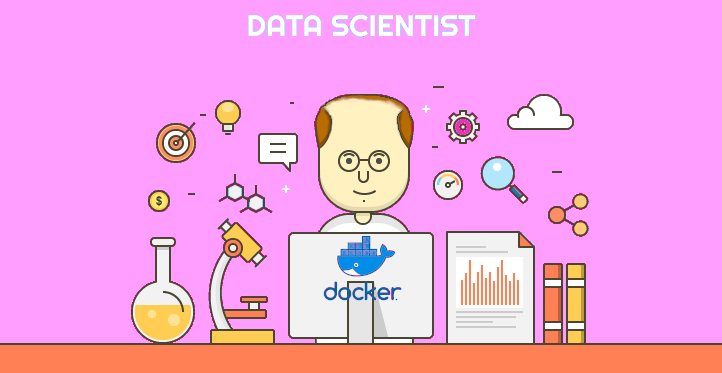

# Comparar Classificação de Vinhos

Este notebook compara vários modelos usando a base Wine disponível no Skit-learn

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Gráficas
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

%matplotlib inline

## Análise dos Dados

In [2]:
raw_data = datasets.load_wine()

In [ ]:
for key,value in raw_data.items():
    print(key,'\n',value,'\n')

# print(raw_data['DESCR'])

In [ ]:
print('data.shape\t',raw_data['data'].shape,
      '\ntarget.shape \t',raw_data['target'].shape)

In [ ]:
features = pd.DataFrame(data=raw_data['data'],columns=raw_data['feature_names'])
data = features
data['target']=raw_data['target']
data['class']=data['target'].map(lambda ind: raw_data['target_names'][ind])
data.head()

In [ ]:
data.describe()

In [ ]:
sns.distplot(data['alcohol'],kde=0)
plt.show()

In [ ]:
for i in data.target.unique():
    sns.histplot(data['alcohol'][data.target==i], # Ou use displot para tê-los separadamente
                 kde=1,label='{}'.format(i))

plt.legend()
plt.show()

In [ ]:
for feature in raw_data['feature_names']:
    print(feature)
    #sns.boxplot(data=data,x=data.target,y=data[feature])
    gs1 = gridspec.GridSpec(3,1)
    ax1 = plt.subplot(gs1[:-1])
    ax2 = plt.subplot(gs1[-1])
    gs1.update(right=0.60)
    sns.boxplot(x=feature,y='class',data=data,ax=ax2)
    sns.kdeplot(data[feature][data.target==0],ax=ax1,label='0')
    sns.kdeplot(data[feature][data.target==1],ax=ax1,label='1')
    sns.kdeplot(data[feature][data.target==2],ax=ax1,label='2')
    ax2.yaxis.label.set_visible(False)
    ax1.xaxis.set_visible(False)
    plt.show()

## Divisão dos Dados

In [3]:
data_train, data_test, label_train, label_test = \
    train_test_split(raw_data['data'],raw_data['target'], test_size=0.2)
print(len(data_train),' samples in training data\n',
      len(data_test),' samples in test data\n', )

142  samples in training data
 36  samples in test data



## Utilização dos Modelos

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import learning_curve 
import time
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score

In [84]:
dict_classifiers = {
    "kNN": {
        'classifier': KNeighborsClassifier(),
        'params': [{
            'n_neighbors': [1, 3, 5, 10],
            'leaf_size': [3, 30]
        }]
    },
    "SVM": {
        'classifier': SVC(),
        'params': [{
            'C': [1, 10, 100, 1000],
            'gamma': [0.001, 0.0001],
            'kernel': ['linear']
         }]
    },
    "Random Forest": {
        'classifier': RandomForestClassifier(),
        'params': {}
    },
    "Decision Tree": {
        'classifier': tree.DecisionTreeClassifier(),
        'params': [{
            'max_depth':[2,None]
        }]
    },    
    "Gradient Boosting Classifier": {
        'classifier': GradientBoostingClassifier(),
        'params': [{
            'learning_rate': [0.05, 0.1],
            'n_estimators' :[10, 20, 30],
            'max_depth':[2,None]
        }]
    },    
    "Naive Bayes": {
        'classifier': GaussianNB(),
        'params': {}
    }    
}

In [78]:
"""
Gerar um gráfico simples da curva de aprendizado de teste e treinamento
    e retorna o tempo que levou para gerar a curva. 

Parametros:
    estimator: tipo de objeto que implementa os métodos "ajuste" e "previsão"
     Um objeto desse tipo que é clonado para cada validação.
    title : string. Título do gráfico.
    X : array-like, shape (n_samples, n_features)
        Vetor de treinamento, onde n_samples é o número de amostras e
         n_features é o número de recursos.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Alvo em relação a X para classificação ou regressão;
        None para aprendizagem não supervisionada. 
    cv : integer, cross-validation generator, optional
        É o número de folds (dobras). Objetos de validação cruzada específicos 
        podem ser passados, consulte Módulo sklearn.cross_validation para a 
        lista de objetos possíveis.
    n_jobs : integer, optional.
        Número de trabalhos a serem executados em paralelo (padrão 5).
"""

def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=5, train_sizes = np.linspace(.6, 1.0, 5)):
    # plt.figure()
    plt.title(title)
    plt.xlabel("Treinamento")
    plt.ylabel("Score")
    
    t_start = time.process_time()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    t_end = time.process_time()
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    t_diff = t_end - t_start
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Treinamento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation")

    plt.legend(loc="best")
    plt.show()
    
    return "{f:.2f} s".format(f = t_diff)

In [77]:
num_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, X_test, Y_test, verbose):
    if verbose:
        print("Análise de", num_classifiers, "classificadores.")
    
    df_results = pd.DataFrame(
        data = np.zeros(shape=(num_classifiers, 5)),
        columns = ['Classificador',
                   'Treinamento', 
                   'Teste',
                   'Tempo Treino',
                   'Tempo Curva'])
    count = 0
    for key, classifier in dict_classifiers.items():
        if verbose:
            print("Início do Treino do:", key)
        t_start = time.process_time()
        grid = GridSearchCV(
            classifier['classifier'], 
            classifier['params'],
            refit=True,
            cv = 10, # 9+1
            scoring = 'accuracy', # scoring metric
            n_jobs = -1
        )
        estimator = grid.fit(X_train, Y_train)
        t_end = time.process_time()
        t_diff = t_end - t_start
        train_score = estimator.score(X_train, Y_train)
        test_score = estimator.score(X_test, Y_test)
        df_results.loc[count,'Classificador'] = key
        df_results.loc[count,'Treinamento'] = train_score
        df_results.loc[count,'Teste'] = test_score
        df_results.loc[count,'Tempo Treino'] = "{f:.2f} s".format(c = key, f = t_diff)
        if verbose:
            print("Treinado {c} em {f:.2f} s".format(c = key, f = t_diff))
        if verbose:
            print("Resultado Gráfico:")
        df_results.loc[count,'Tempo Curva'] = plot_learning_curve(estimator, "{}".format(key), X_train, Y_train, cv=2)
        count += 1
        
    return df_results

Análise de 5 classificadores.
Início do Treino do: kNN
Treinado kNN em 0.21 s
Resultado Gráfico:


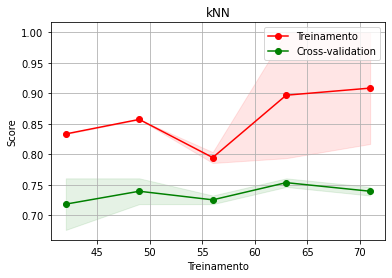

Início do Treino do: Linear SVC
Treinado Linear SVC em 0.18 s
Resultado Gráfico:


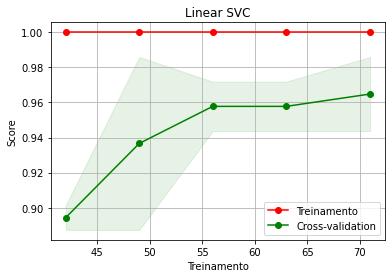

Início do Treino do: Random Forest
Treinado Random Forest em 0.25 s
Resultado Gráfico:


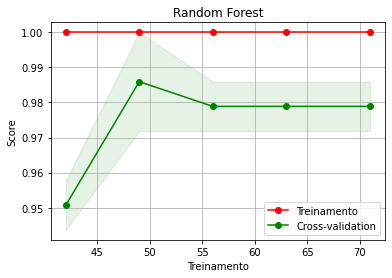

Início do Treino do: Decision Tree
Treinado Decision Tree em 0.05 s
Resultado Gráfico:


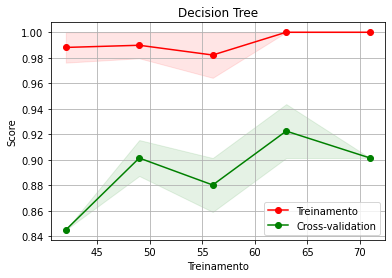

Início do Treino do: Gradient Boosting Classifier
Treinado Gradient Boosting Classifier em 0.33 s
Resultado Gráfico:


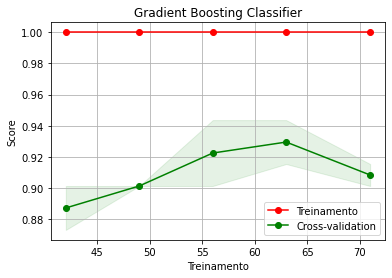

Início do Treino do: Naive Bayes
Treinado Naive Bayes em 0.03 s
Resultado Gráfico:


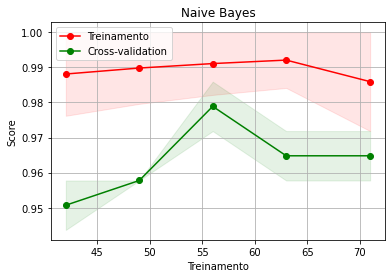

,Classificador,Treinamento,Teste,Tempo Treino,Tempo Curva
2,Random Forest,1.000000,0.972222,0.25 s,0.05 s
5,Naive Bayes,0.985915,0.972222,0.03 s,0.04 s
1,Linear SVC,1.000000,0.861111,0.18 s,0.05 s
3,Decision Tree,1.000000,0.861111,0.05 s,0.04 s
4,Gradient Boosting Classifier,1.000000,0.861111,0.33 s,0.05 s
0,kNN,1.000000,0.694444,0.21 s,0.05 s


In [83]:
df_results = batch_classify(data_train, label_train, data_test, label_test, True)
display(df_results.sort_values(by='Teste', ascending=False))